## Main code

In [1]:
# Things for Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd drive/MyDrive/MacAI

/content/drive/MyDrive/MacAI


In [3]:
# Install a dependency
!pip install torchsummaryX

In [4]:
from lib import medzoo
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib import losses3D
from torch.utils.checkpoint import checkpoint_sequential
from skimage import transform
import nibabel as nb

using_TPU = False
if using_TPU:
  import torch_xla
  import torch_xla.core.xla_model as xm

In [5]:
# Get bounding box of a 3D image, shamelessly stolen from the following link.
# There's probably actually a way to rotate an image to fit into the smallest
# bounding box possible based on scipy.optimize, but whatever
# https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax

Space conserving factor of 2.083 by brain masking and cropping


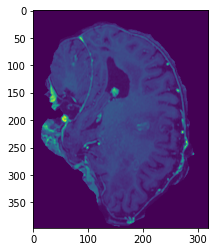

In [6]:
# Load a file and apply brain mask (obtained using FSMRIB library)
# then crop image

seg = nb.load('files/segmentation.nii.gz').get_fdata()
t1 = nb.load('files/T1.nii').get_fdata()/1000
brain_mask = nb.load('files/T1_mask.nii.gz').get_fdata()
t1[brain_mask==0] = 0
xmin, xmax, ymin, ymax, zmin, zmax = bbox2_3D(t1)
t1 = t1[xmin:xmax, ymin:ymax]#, zmin:zmax]
seg = seg[xmin:xmax, ymin:ymax]#, zmin:zmax]
plt.imshow(t1[220])

print('Space conserving factor of ' + str(round((512*512*320)/np.prod(t1.shape), 4)) + ' by brain masking and cropping')

In [7]:
# This shouldn't be a thing in the final model, but U-net complains
# if each dimension isn't divisible by something like 16 or 32
# This should be easily fixable by changing the padding in the UNet3D
t1 = transform.resize(t1, [320, 400, 320])
seg = transform.resize(seg, [320, 400, 320])

In [8]:
# More code shamelessly stolen from stack overflow, makes pytorch use GPU

if using_TPU:
  device = xm.xla_device()
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  if device.type != 'cpu':
      print(torch.cuda.get_device_name(0))
  print('Allocated:', round(torch.cuda.memory_allocated()/1024**3,1), 'GB')
  print('Reserved:', round(torch.cuda.memory_reserved()/1024**3,1), 'GB')
  
print('Using device:', device)
print()


Tesla T4
Allocated: 0.0 GB
Reserved: 0.0 GB
Using device: cuda



In [9]:
# So (a single) raw image series are about 8-16x too big to fit using batch size 1
# The optimizations that I've identified here that we need are:
# 16-bit precision (or less, but Pytorch doesn't support it): Reduction by factor 2
# Brain masking and cropping the brain - in this case, reduction by a factor of 2
# Making the network have 2x less filters works, I guess the true amount of reduction was less than 16x
# Gradient checkpointing gives marginal improvements, but not the massive ones we were looking for
# This is probably because most of the memory is in the first (largest) layer

# Next steps
# checkpoint_sequential is weird
# Also, you'd still have to reduce the high number of image channels to one or two channels

t1_tensor = torch.Tensor(np.expand_dims(np.expand_dims(t1, axis=0), axis=0)).half().cuda()#to(device)
seg_tensor = torch.Tensor(np.expand_dims(np.expand_dims(seg, axis=0), axis=0)).half().cuda()#to(device)


In [10]:
t1_tensor.requires_grad = True
seg_tensor.requires_grad = True

In [11]:
import torch.nn as nn
import torch
from torchsummary import summary
import torchsummaryX
from lib.medzoo.BaseModelClass import BaseModel
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

class UNet3D(BaseModel):
    """
    Implementations based on the Unet3D paper: https://arxiv.org/abs/1606.06650
    """

    def __init__(self, in_channels, n_classes, base_n_filter=8):
        super(UNet3D, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.base_n_filter = base_n_filter

        self.lrelu = nn.LeakyReLU()
        self.dropout3d = nn.Dropout3d(p=0.6)
        self.upsacle = nn.Upsample(scale_factor=2, mode='nearest')
        self.softmax = nn.Softmax(dim=1)

        self.conv3d_c1_1 = nn.Conv3d(self.in_channels, self.base_n_filter, kernel_size=3, stride=1, padding=1,
                                     bias=False)
        self.conv3d_c1_2 = nn.Conv3d(self.base_n_filter, self.base_n_filter, kernel_size=3, stride=1, padding=1,
                                     bias=False)
        self.lrelu_conv_c1 = self.lrelu_conv(self.base_n_filter, self.base_n_filter)
        self.inorm3d_c1 = nn.InstanceNorm3d(self.base_n_filter)

        self.conv3d_c2 = nn.Conv3d(self.base_n_filter, self.base_n_filter * 2, kernel_size=3, stride=2, padding=1,
                                   bias=False)
        self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter * 2, self.base_n_filter * 2)
        self.inorm3d_c2 = nn.InstanceNorm3d(self.base_n_filter * 2)

        self.conv3d_c3 = nn.Conv3d(self.base_n_filter * 2, self.base_n_filter * 4, kernel_size=3, stride=2, padding=1,
                                   bias=False)
        self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter * 4, self.base_n_filter * 4)
        self.inorm3d_c3 = nn.InstanceNorm3d(self.base_n_filter * 4)

        self.conv3d_c4 = nn.Conv3d(self.base_n_filter * 4, self.base_n_filter * 8, kernel_size=3, stride=2, padding=1,
                                   bias=False)
        self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter * 8, self.base_n_filter * 8)
        self.inorm3d_c4 = nn.InstanceNorm3d(self.base_n_filter * 8)

        self.conv3d_c5 = nn.Conv3d(self.base_n_filter * 8, self.base_n_filter * 16, kernel_size=3, stride=2, padding=1,
                                   bias=False)
        self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter * 16, self.base_n_filter * 16)
        self.norm_lrelu_upscale_conv_norm_lrelu_l0 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter * 16,
                                                                                             self.base_n_filter * 8)

        self.conv3d_l0 = nn.Conv3d(self.base_n_filter * 8, self.base_n_filter * 8, kernel_size=1, stride=1, padding=0,
                                   bias=False)
        self.inorm3d_l0 = nn.InstanceNorm3d(self.base_n_filter * 8)

        self.conv_norm_lrelu_l1 = self.conv_norm_lrelu(self.base_n_filter * 16, self.base_n_filter * 16)
        self.conv3d_l1 = nn.Conv3d(self.base_n_filter * 16, self.base_n_filter * 8, kernel_size=1, stride=1, padding=0,
                                   bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l1 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter * 8,
                                                                                             self.base_n_filter * 4)

        self.conv_norm_lrelu_l2 = self.conv_norm_lrelu(self.base_n_filter * 8, self.base_n_filter * 8)
        self.conv3d_l2 = nn.Conv3d(self.base_n_filter * 8, self.base_n_filter * 4, kernel_size=1, stride=1, padding=0,
                                   bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l2 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter * 4,
                                                                                             self.base_n_filter * 2)

        self.conv_norm_lrelu_l3 = self.conv_norm_lrelu(self.base_n_filter * 4, self.base_n_filter * 4)
        self.conv3d_l3 = nn.Conv3d(self.base_n_filter * 4, self.base_n_filter * 2, kernel_size=1, stride=1, padding=0,
                                   bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l3 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter * 2,
                                                                                             self.base_n_filter)

        self.conv_norm_lrelu_l4 = self.conv_norm_lrelu(self.base_n_filter * 2, self.base_n_filter * 2)
        self.conv3d_l4 = nn.Conv3d(self.base_n_filter * 2, self.n_classes, kernel_size=1, stride=1, padding=0,
                                   bias=False)

        self.ds2_1x1_conv3d = nn.Conv3d(self.base_n_filter * 8, self.n_classes, kernel_size=1, stride=1, padding=0,
                                        bias=False)
        self.ds3_1x1_conv3d = nn.Conv3d(self.base_n_filter * 4, self.n_classes, kernel_size=1, stride=1, padding=0,
                                        bias=False)
        self.sigmoid = nn.Sigmoid()

    def conv_norm_lrelu(self, feat_in, feat_out):
        return  nn.Sequential(
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm3d(feat_out),
            nn.LeakyReLU())
        

    def norm_lrelu_conv(self, feat_in, feat_out):
        return nn.Sequential(
            nn.InstanceNorm3d(feat_in),
            nn.LeakyReLU(),
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

    def lrelu_conv(self, feat_in, feat_out):
        return nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

    def norm_lrelu_upscale_conv_norm_lrelu(self, feat_in, feat_out):
        return nn.Sequential(
            nn.InstanceNorm3d(feat_in),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # should be feat_in*2 or feat_in
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm3d(feat_out),
            nn.LeakyReLU())

    def forward(self, x):
        #  Level 1 context pathway
        out = checkpoint(self.conv3d_c1_1, x)
        residual_1 = out
        out = self.lrelu(out)
        out = checkpoint(self.conv3d_c1_2, out)
        out = self.dropout3d(out)
        out = checkpoint(self.lrelu_conv_c1, out)
        # Element Wise Summation
        out += residual_1
        context_1 = self.lrelu(out)
        out = self.inorm3d_c1(out)
        out = self.lrelu(out)

        # Level 2 context pathway
        out = checkpoint(self.conv3d_c2, out)
        residual_2 = out
        out = checkpoint(self.norm_lrelu_conv_c2, out)
        out = self.dropout3d(out)
        out = checkpoint(self.norm_lrelu_conv_c2, out)
        out += residual_2
        out = self.inorm3d_c2(out)
        out = self.lrelu(out)
        context_2 = out

        # Level 3 context pathway
        out = checkpoint(self.conv3d_c3, out)
        residual_3 = out
        out = checkpoint(self.norm_lrelu_conv_c3,out)
        out = self.dropout3d(out)
        out = checkpoint(self.norm_lrelu_conv_c3,out)
        out += residual_3
        out = self.inorm3d_c3(out)
        out = self.lrelu(out)
        context_3 = out

        # Level 4 context pathway
        out = checkpoint(self.conv3d_c4, out)
        residual_4 = out
        out = checkpoint(self.norm_lrelu_conv_c4,out)
        out = self.dropout3d(out)
        out = checkpoint(self.norm_lrelu_conv_c4,out)
        out += residual_4
        out = self.inorm3d_c4(out)
        out = self.lrelu(out)
        context_4 = out

        # Level 5
        out = checkpoint(self.conv3d_c5, out)
        residual_5 = out
        out = checkpoint(self.norm_lrelu_conv_c5,out)
        out = self.dropout3d(out)
        out = checkpoint(self.norm_lrelu_conv_c5,out)
        out += residual_5
        out = checkpoint(self.norm_lrelu_upscale_conv_norm_lrelu_l0,out)

        out = checkpoint(self.conv3d_l0, out)
        out = self.inorm3d_l0(out)
        out = self.lrelu(out)

        # Level 1 localization pathway
        out = torch.cat([out, context_4], dim=1)
        out = checkpoint(self.conv_norm_lrelu_l1, out)
        out = checkpoint(self.conv3d_l1,out)
        out = checkpoint(self.norm_lrelu_upscale_conv_norm_lrelu_l1,out)

        # Level 2 localization pathway
        # print(out.shape)
        # print(context_3.shape)
        out = torch.cat([out, context_3], dim=1)
        out = checkpoint(self.conv_norm_lrelu_l2, out)
        ds2 = out
        out = checkpoint(self.conv3d_l2,out)
        out = checkpoint(self.norm_lrelu_upscale_conv_norm_lrelu_l2,out)

        # Level 3 localization pathway
        out = torch.cat([out, context_2], dim=1)
        out = checkpoint(self.conv_norm_lrelu_l3,out)
        ds3 = out
        out = checkpoint(self.conv3d_l3,out)
        out = checkpoint(self.norm_lrelu_upscale_conv_norm_lrelu_l3,out)

        # Level 4 localization pathway
        out = torch.cat([out, context_1], dim=1)
        out = checkpoint(self.conv_norm_lrelu_l4,out)
        out_pred = checkpoint(self.conv3d_l4,out)

        ds2_1x1_conv = checkpoint(self.ds2_1x1_conv3d, ds2)
        ds1_ds2_sum_upscale = self.upsacle(ds2_1x1_conv)
        ds3_1x1_conv = checkpoint(self.ds3_1x1_conv3d,ds3)
        ds1_ds2_sum_upscale_ds3_sum = ds1_ds2_sum_upscale + ds3_1x1_conv
        ds1_ds2_sum_upscale_ds3_sum_upscale = self.upsacle(ds1_ds2_sum_upscale_ds3_sum)

        out = out_pred + ds1_ds2_sum_upscale_ds3_sum_upscale
        seg_layer = out
        return seg_layer

    def test(self,device='cpu'):

        input_tensor = torch.rand(1, 2, 32, 32, 32)
        ideal_out = torch.rand(1, self.n_classes, 32, 32, 32)
        out = self.forward(input_tensor)
        assert ideal_out.shape == out.shape
        summary(self.to(torch.device(device)), (2, 32, 32, 32),device='cpu')
        # import torchsummaryX
        # torchsummaryX.summary(self, input_tensor.to(device))
        print("Unet3D test is complete")


In [12]:
print(t1_tensor.shape)

# If base_n_filter=6 using default medzoo.UNet3D, goes OOM
# but if base_n_filter=6 using checkpointed medzoo.UNet3D, works
# Definitely room for improvement, it is quite slow as implemented here
unet = UNet3D(1,1, base_n_filter=6).cuda() 
unet.half()

print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')

optimizer = torch.optim.Adam(unet.parameters()) 
# Pixel-wise CE gives some weird shape error with "weights"

loss_function = losses3D.WeightedSmoothL1Loss()
for i in range(1):
  outputs = unet(t1_tensor)
  loss = loss_function(outputs, seg_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print(loss)

torch.Size([1, 1, 320, 400, 320])
Allocated: 0.2 GB
tensor(0.1796, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>)


In [13]:
#from lib.medzoo.HighResNet3D import HighResNet3D
#unet = HighResNet3D(1,1).cuda()#to(device) 
#unet.half()

#print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')

#optimizer = torch.optim.Adam(unet.parameters()) 
# Pixel-wise CE gives some weird shape error with "weights"

#modules = [module for k, module in unet._modules.items()]


#loss_function = losses3D.WeightedSmoothL1Loss()
#for i in range(1):
# outputs = checkpoint_sequential(modules, 4, t1_tensor)
  #outputs = unet(t1_tensor)
#  loss = loss_function(outputs, seg_tensor)
#  print(loss)
#  optimizer.zero_grad()
#  loss.backward()
#  optimizer.step()

In [14]:
# Wait this experiment makes no sense
#import sys
#import os
#models = [
#medzoo.Unet3D.UNet3D(1, 1),
#medzoo.HighResNet3D(1, 1),
#medzoo.DenseVoxelNet(1,1 ),
#medzoo.ResNet3D_VAE.ResNet3dVAE(1,1 ),
#medzoo.Vnet.VNetLight(1,1),
#medzoo.SkipDenseNet3D.SkipDenseNet3D(1,1)
#]

#if not os.path.exists('model_sizes'):
#  os.mkdir('model_sizes')
#types = ['Unet', 'ResNet', 'VoxelNet', 'ResNetVAE','VNet']
#for i, model in enumerate(models):
 # model.eval()
#  torch.save(model.state_dict(), 'model_sizes/'+types[i]+'.pt')



In [15]:
# Every single network crashes even using 1 series
# Also some might have problems with image sizes that aren't multiples of 2, idk


# Crashes list
# Unet3D.UNet3D(1, 1)
# medzoo.HighResNet3D(1, 1)
# medzoo.DenseVoxelNet(1,1 )
# medzoo.ResNet3D_VAE.ResNet3dVAE(1,1 )
# VNetLight
# SkipDenseNet3D
# doesn't work for 1 channel
# medzoo.HyperDenseNet_2Mod(1, 1)
# medzoo.ResNet3DMedNet.ResNetMed3D(1,1)
# still crashes with TPU which has 64 GB HBM

# Just stuff for TPUs, but didn't seem to work
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py 
